## Simulating Contact Processes

Consider contact process $( \eta_{t})_{t\geq0}$ with state space $S = (0, 1)^{1, ...,L}$. Let
$$c(\eta, \eta^{i}) = \eta(i) + (1-\eta(i))\Sigma_{j \neq i} q(j, i) \eta(j)$$

Assume a fully connected network that is $q(i, j) = \lambda$ for all $i, j$ for $\lambda$ a positive real constant.
At each timestep select an individual i according to
$$p_{i} = \frac{c(\eta, \eta^{i})}{\Sigma^{N}_{j=1}c(\eta, \eta^{j})}$$
and update $\eta_{t+1} = \eta_{t}^{i}$

In [3]:
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

### 1a 

Use the gillespie algorithm to simulate several realisations of the contact process with parameters, L = 50, $\lambda = \frac{1.5}{L}$, and five initially infected individuals.

In [6]:
def compute_c(eta, q):
    c = eta + (1 - eta)*np.sum(eta)*q

    #if eta(i) = 1 sum doesnt matter, if eta(i) = 0 then including in some doesnt matter so dont have to worry about i neq j
    return c
    

def gillespie(eta0, lamda, iterations):
    eta_update = copy.deepcopy(eta0) #needed to ensure that eta doesnt get assigned to zero
    max_infected = np.sum(eta_update)
    peak_time = 0
    infection_count = 0
    
    for i in range(0, iterations):
        if np.sum(eta_update) == 0:
            average_number_infections = infection_count/len(eta_update)
            break
        c = compute_c(eta_update, lamda)
        R = np.sum(c) 
        prob = c/R
        state_indx = np.random.choice(len(eta_update), p=prob)
        if eta_update[state_indx] == 1:
            eta_update[state_indx] = 0
        else:
            eta_update[state_indx] = 1
            infection_count += 1
            average_number_infections = infection_count/len(eta_update)
        if np.sum(eta_update) > max_infected:
            max_infected = np.sum(eta_update)
            peak_time = i
    return eta_update, i, max_infected, peak_time, average_number_infections


In [7]:
L = 50
lamda = 1.5/L

#as the q(i, j) are all equal you can put the 1, 0 anywhere within the population array
eta = np.zeros(L)
eta[0:5] = 1

updated_eta, i, max_infected, peak_time, average_individual_infections = gillespie(eta, lamda, 100000)
print('Disease has died out after', i, 'steps')

Disease has died out after 2791 steps


Use this to find out the average number of timesteps required for the disease to die out and how long each simulations take.

In [28]:
realisations = 100

i_array = []
time_array = []
max_infected_array = []
peak_time_array = []
average_infec = []

for i in range(0, 100):
    start = time.time()
    final_eta, i, max_infected, peak_time, average_individual_infections = gillespie(eta, lamda, 100000)
    end = time.time()
    i_array.append(i)
    time_array.append((end-start))
    max_infected_array.append(max_infected)
    peak_time_array.append(peak_time)
    average_infec.append(average_individual_infections)


Calculate the maximum number of infected individuals and the iteration at which this occurs. And the average number of times each individual is infected.

- I have adapted the gillespie algorithm above to do this

In [29]:
average_i = np.mean(i_array)
average_time = np.mean(time_array)
average_max_infected = np.mean(max_infected_array)
average_peak_time = np.mean(peak_time_array)
average_individual_infec = np.mean(average_individual_infections)


print('Average iterations before epidemic dies:', average_i)
print('Average time of simulations:', average_time)
print('Average max number of infections', average_max_infected)
print('Average time of peak infection', average_peak_time)
print('Average number of times an individual is infected', average_individual_infec)

Average iterations before epidemic dies: 2440.48
Average time of simulations: 0.10618288040161133
Average max number of infections 25.59
Average time of peak infection 1059.08
Average number of times an individual is infected 17.12


Why have we chosen $\lambda$ as a multiple of $\frac{1}{L}$??

- So that for larger population sizes the growth/decay rate of the disease is adequate.??

## Section 2

Define a new process $N_{t} = \Sigma^{L}_{i=1}\eta_{t}(i)$, describes the proportion of individuals who are infected at time $t \geq 0$. At each timestep either someone is infected or someone recovers, therefor can derive:
$$P[N_{t+1} = n + 1 | N_t = n] = \frac{\lambda n (L - n)}{\lambda n (L - n) + n}$$
$$P[N_{t+1} = n - 1 | N_t = n] = \frac{n}{\lambda n (L - n) + n}$$
for $n = 1, ..., L$ and the boundary condition: $P[N_{t+1} = 0 | N_t = 0] = 1$

#### 2a 
The statespace of $N_{t}$ is $[0, 1, 2, ...50]$, can predict that it behaves as above??

#### 2b
Adapt previous gillespie algorithm to monitor $N_{t}$. Plot some realisations aswell as their means and variances.

In [71]:
def gillespie_adap(eta0, lamda, iterations):
    eta_update = copy.deepcopy(eta0) #needed to ensure that eta doesnt get assigned to zero
    N_t = []
    for i in range(0, iterations):
        if np.sum(eta_update) == 0:
            break
        c = compute_c(eta_update, lamda)
        R = np.sum(c) 
        prob = c/R
        state_indx = np.random.choice(len(eta_update), p=prob)
        if eta_update[state_indx] == 1:
            eta_update[state_indx] = 0
        else:
            eta_update[state_indx] = 1
        N_t.append(np.sum(eta_update))
    return N_t, i


In [72]:
L = 50
lamda = 1.5/L

#as the q(i, j) are all equal you can put the 1, 0 anywhere within the population array
eta = np.zeros(L)
eta[0:5] = 1

N_t, i = gillespie_adap(eta, lamda, 100000)
print('Disease has died out after', i, 'steps')

Disease has died out after 95 steps


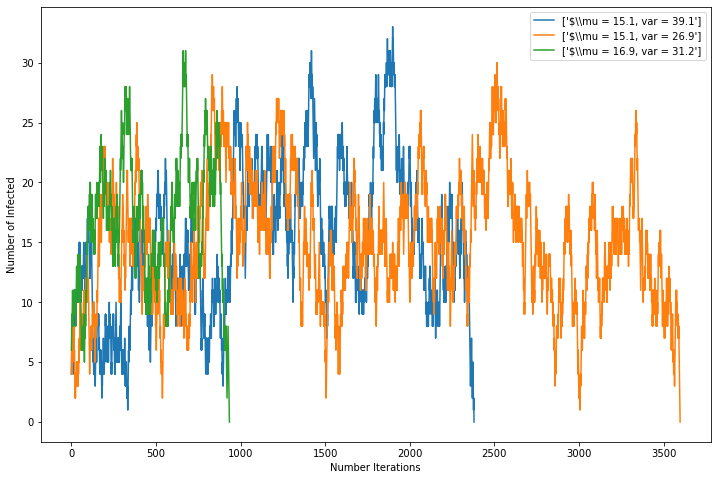

In [73]:
fig, axes = plt.subplots(1, 1, figsize = (12, 8))

for i in range(0, 3):
    N_t, i = gillespie_adap(eta, lamda, 100000)
    mean_N = np.mean(N_t)
    var_N = np.var(N_t)
    axes.plot(N_t, label = [f'$\mu = {mean_N:.1f}, var = {var_N:.1f}'])
    axes.set_xlabel('Number Iterations')
    axes.set_ylabel('Number of Infected')
    axes.set_title('Gillespie')
plt.legend()
plt.show()

Are the mean and variance appropriate statistics???

#### 2c
As $N_{t}$ is a markov process, do not need to use the gillespie algorithm. Write new algorithm.

In [76]:
def MCMC(no_infected, lamda,  L):
    N_t = []
    N_t.append(no_infected)
    i = 0
    while no_infected > 0:
        prob_infec = (lamda*no_infected*(L-no_infected))/((lamda*no_infected*(L-no_infected))+no_infected)
        rand_num = np.random.uniform(0, 1)
        if rand_num < prob_infec:
            no_infected +=1
        else:
            no_infected -=1
        N_t.append(no_infected)
        i+=1
    return N_t, i

            

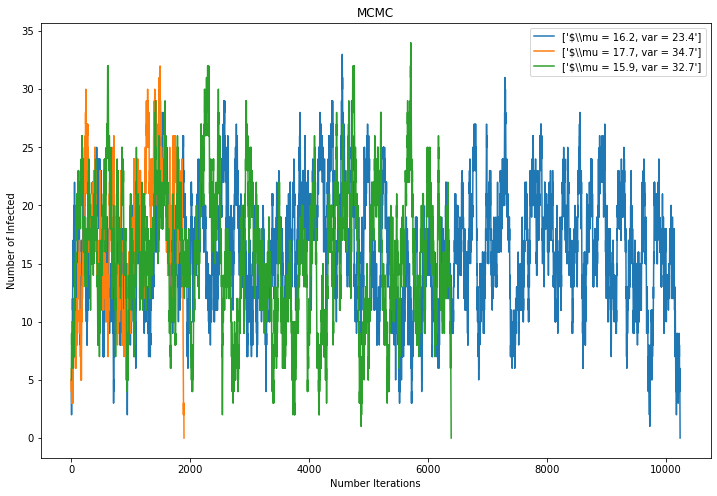

In [82]:
L = 50
lamda = 1.5/L
init_infec = 5

fig1, axes1 = plt.subplots(1, 1, figsize = (12, 8))


for i in range(0, 3):
    N_t, i = MCMC(init_infec, lamda, L)
    mean_N = np.mean(N_t)
    var_N = np.var(N_t)
    axes1.plot(N_t, label = [f'$\mu = {mean_N:.1f}, var = {var_N:.1f}'])
    axes1.set_xlabel('Number Iterations')
    axes1.set_ylabel('Number of Infected')
    axes1.set_title('MCMC')
    
plt.legend()
plt.show()

comparisson of both: MCMC is faster??, but contains less information

In [ ]:
#section - extinction time same as simulation end time - photo gives informatiob